<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Описание данных**  
RowNumber — индекс строки в данных  
CustomerId — уникальный идентификатор клиента 
Surname — фамилия 
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — сколько лет человек является клиентом банка  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата  
**Целевой признак**  
Exited — факт ухода клиента  

## Подготовка данных

In [25]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV

In [26]:
df = pd.read_csv('/datasets/Churn.csv')

print(df.head(5))

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [27]:
df.dtypes
#проверим столбцы на правильность формата

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [29]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [30]:
#в датафрейме присутствуют данные из 3-х стран

In [31]:
# удалим колонки CustomerId,Surname, так как id и фамилия клиента никак не влияют на факт ухода клиента.
df.drop(columns=['CustomerId', 'Surname', 'RowNumber'],axis=1,inplace=True)

In [32]:
df.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Рассмотрим показатель "Tenure" подробнее, изучим природу пропусков

In [33]:
df['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

<AxesSubplot:>

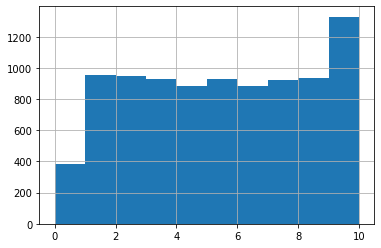

In [34]:
df['Tenure'].hist()

На распределении видно, что количество клиентов по годам практически одинакого, только клиентов с 10-летним стажем немного больше. пропуски можно заменить случайными числами, дабы не влиять на выборку.

In [35]:
#заменим пропуски случайным числом в диапазоне 0:10
random_grades = np.random.randint(0, 10)

new_grades = df.Tenure.fillna(random_grades)

df['Tenure'].fillna(new_grades,inplace=True)
print(df['Tenure'])


0        2.0
1        1.0
2        8.0
3        1.0
4        2.0
        ... 
9995     5.0
9996    10.0
9997     7.0
9998     3.0
9999     0.0
Name: Tenure, Length: 10000, dtype: float64


<AxesSubplot:>

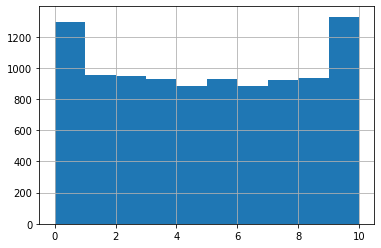

In [36]:
# Посмотрим повторно гистограмму по столбцу Tenure
df['Tenure'].hist()

Найдем корреляцию между числовыми признаками 

In [37]:
number = ['CreditScore','Age','Balance','NumOfProducts','EstimatedSalary','Tenure']

In [38]:
df.loc[:,number].corr()

,CreditScore,Age,Balance,NumOfProducts,EstimatedSalary,Tenure
CreditScore,1.000000,-0.003965,0.006268,0.012238,-0.001384,0.003087
Age,-0.003965,1.000000,0.028308,-0.030680,-0.007201,-0.007368
Balance,0.006268,0.028308,1.000000,-0.304180,0.012797,-0.005821
NumOfProducts,0.012238,-0.030680,-0.304180,1.000000,0.014204,0.010106
EstimatedSalary,-0.001384,-0.007201,0.012797,0.014204,1.000000,0.011225
Tenure,0.003087,-0.007368,-0.005821,0.010106,0.011225,1.000000


Из таблицы видно, что максимальная корреляция не превышает 30%(0.3) - это корреляция между количеством продуктов банка и балансом на счете.

Добавим целевой признак и сравним корреляцию с ним

In [39]:
df.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.003087,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.007368,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.003087,-0.007368,1.000000,-0.005821,0.010106,0.021387,-0.025856,0.011225,-0.013319
Balance,0.006268,0.028308,-0.005821,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.010106,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.021387,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.025856,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.011225,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.013319,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


Максимальная корреляция - 0.28 видна между целевым признаком "exited" и возрастом клиента, что может говорит о том, что чем страше клиент, тем вероятнее он покинет банк.

## Исследование задачи

In [40]:
#закодируем данные и разделим их на обучающую, валидационную и тестовую

In [41]:
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df),
                            columns=df.columns)

In [42]:
df_train, df_valid = train_test_split(df_ordinal, test_size = 0.4, random_state=12345)
df_valid, df_test = train_test_split(df_valid, test_size = 0.5, random_state=12345)

In [43]:
print(f'Размер выборки для тренировки: {df_train.shape}\nРазмер выборки для валидации: {df_valid.shape}\nРазмер выборки для теста: {df_test.shape}')

Размер выборки для тренировки: (6000, 11)
Размер выборки для валидации: (2000, 11)
Размер выборки для теста: (2000, 11)


In [44]:
#Kод ревьюера (Например, вот так)
%pip install fast_ml
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'Exited', 
                                                                            train_size=0.6, valid_size=0.2, test_size=0.2)


     |████████████████████████████████| 42 kB 202 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [45]:
#выделим признаки на тренировочной и валидационной выборках
features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']

features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited']

features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited']

In [46]:
#отмасштабируем количественные признаки
numeric = ['CreditScore','Age','Balance','NumOfProducts','EstimatedSalary','Tenure']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Посмотрим на результаты при несбалансированной классификации

In [47]:
#начнем с решающего дерева
#создадим функцию, которая на вход принимает значения тренировочных данных,
#а на выходе получает значения auc-roc и f1-меру, а также оптимальное значение гиперпараметра
def decision_tree_classifier_scores(features_train, target_train):
    roc_auc = 0
    f1 = 0
    max_depth_decision_tree = 1
    for i in range(1,10):
        model = DecisionTreeClassifier(random_state=12345, max_depth=i)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1_result = f1_score(target_valid, predicted_valid)
        if f1_result > f1:
            f1 = f1_result
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
            max_depth_decision_tree = i
            best_model = model
    return f1, roc_auc, max_depth_decision_tree, best_model

f1, roc_auc, max_depth_decision_tree, _ = decision_tree_classifier_scores(features_train, target_train)         
print('Максимальное значение f1-меры',f1)        
print('Максимальное значение AUC-ROC',roc_auc)     
print('Наилучший гиперпараметр "глубина" =',max_depth_decision_tree)

Максимальное значение f1-меры 0.5528700906344411
Максимальное значение AUC-ROC 0.8203012055480615
Наилучший гиперпараметр "глубина" = 4


In [48]:
#повторим алгоритм уже с случайным лесом, настраиваемым гиперпараметром будет количество деревьев

def random_forest_classifier_scores(features_train, target_train):
    roc_auc = 0
    f1 = 0
    n_estimators = 1
    for i in range(1,50):
        model = RandomForestClassifier(random_state=12345, n_estimators=i)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1_result = f1_score(target_valid, predicted_valid)
        if f1_result > f1:
            f1 = f1_result
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
            n_estimators = i
            best_model = model
    return f1, roc_auc, n_estimators, best_model
f1, roc_auc, n_estimators, _ = random_forest_classifier_scores(features_train, target_train)         
print('Максимальное значение f1-меры',f1)        
print('Максимальное значение AUC-ROC',roc_auc)     
print('Наилучший гиперпараметр "estimators"',n_estimators)


Максимальное значение f1-меры 0.5925925925925927
Максимальное значение AUC-ROC 0.8190823498811388
Наилучший гиперпараметр "estimators" 19


In [49]:
#также поступим и с логистической регрессией

def logistic_regression_scores(features_train,target_train,class_weight=None):
    f1 = 0
    roc_auc = 0
    threshold = 0

    model = LogisticRegression(random_state=12345, solver='liblinear', class_weight=class_weight)
    model.fit(features_train, target_train)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    for threshold_result in np.arange(0, 0.8, 0.02):
        predicted_valid = probabilities_one_valid > threshold
        precision_result = precision_score(target_valid, predicted_valid)
        recall_result = recall_score(target_valid, predicted_valid)
        f1_result = f1_score(target_valid, predicted_valid)
        print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.3f}".format(
            threshold_result, precision_result, recall_result, f1_result))
        if f1_result > f1:
            f1 = f1_result
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
            threshold = threshold_result
    return f1, roc_auc, threshold
f1, roc_auc, threshold = logistic_regression_scores(features_train,target_train)
print()        
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('threshold',threshold)

Порог = 0.00 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.02 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.04 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.06 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.08 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.10 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.12 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.14 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.16 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.18 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.20 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.22 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.24 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.26 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.28 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.30 | Точность = 0.209, Полнота = 1.000, f1 = 0.346
Порог = 0.32 | Точность 

**Вывод**  
Максимального значения f1-меры при разбалансированных классах удалось достичь, используя модель случайного леса - 0.5878877400295421.

## Борьба с дисбалансом

In [50]:
# избавлюсь от разбаланса путем увеличения выборки  

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)
features_train.shape, features_upsampled.shape


((6000, 10), (16764, 10))

In [51]:
#также поступлю с валидационной и тестовой выборками.
features_valid, target_valid = upsample(features_valid, target_valid, 10)
features_test, target_test = upsample(features_test, target_test, 10)

In [52]:
#обучим модель randomTreeClassfier на сбалансированны данных

f1, roc_auc, max_depth_decision_tree, model_tree = decision_tree_classifier_scores(features_upsampled,
                                                                                   target_upsampled)
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('max_depth_decision_tree',max_depth_decision_tree) 

f1_score 0.861504907306434
roc_auc_score 0.7915257774363503
max_depth_decision_tree 3


In [53]:
#обучим модель RandomForestClassifier на сбалансированны данных

f1, roc_auc, n_estimators, random_forest_model = random_forest_classifier_scores(features_upsampled,
                                                                                    target_upsampled)
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('n_estimators',n_estimators)



f1_score 0.6819228997081862
roc_auc_score 0.8247622777781138
n_estimators 35


In [54]:
#Обучим сбалансированную модель LogisticRegression

f1, roc_auc, threshold = logistic_regression_scores(features_upsampled, target_upsampled)
print()        
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('threshold',threshold)


Порог = 0.00 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.02 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.04 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.06 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.08 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.10 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.12 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.14 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.16 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.18 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.20 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.22 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.24 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.26 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.28 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.30 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.32 | Точность 

**Промежуточный вывод**  
Максимальный результат f1-меры, при использовании увеличения выборки, получен, используя модель решающего дерева - 0.8615.

In [55]:
#для подтверждения своих выводов, использую второй способ баланса - уменьшение выборки(downsampling)

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
features_train.shape, features_downsampled.shape

((6000, 10), (1676, 10))

In [56]:
f1, roc_auc, max_depth_decision_tree, model_tree = decision_tree_classifier_scores(features_downsampled,
                                                                                   target_downsampled)
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('max_depth_decision_tree',max_depth_decision_tree) 

f1_score 0.861504907306434
roc_auc_score 0.7675584778519107
max_depth_decision_tree 3


In [57]:
f1, roc_auc, n_estimators, random_forest_model = random_forest_classifier_scores(features_downsampled,
                                                                                   target_downsampled)
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('n_estimators',n_estimators)

f1_score 0.8619112940100594
roc_auc_score 0.8235116653258246
n_estimators 49


In [58]:
f1, roc_auc, threshold = logistic_regression_scores(features_downsampled, target_downsampled)
print()        
print('f1_score',f1)        
print('roc_auc_score',roc_auc)     
print('threshold',threshold)

Порог = 0.00 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.02 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.04 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.06 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.08 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.10 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.12 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.14 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.16 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.18 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.20 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.22 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.24 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.26 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.28 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.30 | Точность = 0.725, Полнота = 1.000, f1 = 0.841
Порог = 0.32 | Точность 

**Вывод**  
при использовании метода уменьшения выборки результат изменился, максимальное значение f1-меры получено с использованием модели случайного леса 0.8619871906011177. Возьмём ее для тестирования



## Тестирование модели

In [59]:
predicted_test = random_forest_model.predict(features_test)
f1 = f1_score(target_test, predicted_test)

probabilities_valid = random_forest_model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_valid)
        
print('f1_score',f1)           
print('roc_auc',roc_auc)

f1_score 0.8712248793084092
roc_auc 0.8231904849708652


Результат устраивает поставленную задачу - f1-мера больше 0.59.

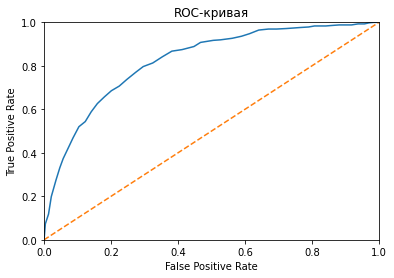

In [60]:
#Чтобы выявить, как сильно наша модель отличается от случайной, построим roc-кривую

probabilities_valid = random_forest_model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds =  roc_curve(target_test, probabilities_one_valid)# < напишите код здесь >

plt.figure()
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")

plt.show()

Исходя из моего результата 0.87 на случайной моделе было бы примерно 0.45. Модель далека от случайной.

**Общий вывод**

В начале работы подготовили и исследовали данные, при проверке по матрице корреляции, выяснилась слабая корреляция в признаках 'NumofProducts' и 'Balance'. Категориальные классы закодировали числами методом OrdinalEncoder() затем привели все числовые признаки к одному масштабу. После этого данные были готовы для обучения моделей. Использовались модели классификации DecisionTreeClassifier, RandomForestClassifier, LogisticRegression

Сначала обучили на несбалансированных классах, получив неудовлетворительные результаты, методом upsempling сбалансировали данные и получили нужное значение f1-меры.